In [113]:
from collections import Counter
import glob
import itertools
from itertools import izip
import os

from IPython.core.display import HTML, Image
from matplotlib import gridspec
from matplotlib_venn import venn3, venn2
import numpy as np
import pandas as pd
import scipy
from scipy.stats import linregress
import seaborn as sns

from gscripts.general import dataviz
from gscripts.general import parsers
from gscripts.general import region_helpers
from gscripts import GO
from gscripts import miso

%matplotlib inline

In [19]:
!mkdir -p /nas3/gpratt/projects/fet_family/analysis/rna_stabality_v3/
!scp -q tscc-login.sdsc.edu:~/projects/fet_family/analysis/rna_stabality_v3/*.{metrics,final.out,txt} /nas3/gpratt/projects/fet_family/analysis/rna_stabality_v3/

In [2]:
gene_id_to_name = region_helpers.gene_id_to_name("/nas3/gpratt/gencode/gencode.v17.annotation.gtf.db")
name_to_gene_id = {value: key for key, value in gene_id_to_name.items()}

#Basic QC

In [3]:
analysis_dir = "/nas3/gpratt/projects/fet_family/analysis/rna_stabality_v3/"
fet_clip = parsers.rnaseq_metrics(analysis_dir)

filtered_guttman_clip = fet_clip[[ "Input Reads",
                            #"Reads After Triming",
                                "Percent Repetative",
                             "repetitive_count",
                            "Uniquely Mapped Reads",
                            "Uniquely mapped reads %",

                            ]]

HTML(filtered_guttman_clip.to_html(formatters={"Input Reads" : parsers.commas,
                                     "Reads After Triming" : parsers.commas,
                                     "Reads after Quality Filtering" : parsers.commas,
                                     "Uniquely Mapped Reads" : parsers.commas,
                                     "repetitive_count" : parsers.commas,

                                     } ))

,Input Reads,Percent Repetative,repetitive_count,Uniquely Mapped Reads,Uniquely mapped reads %
NPC0_EWS,"10,865,722",0.3176206,"5,481,879","6,530,226",88.07%
NPC0_FUS,"7,266,698",0.7224433,"6,909,343","1,605,188",79.59%
NPC0_TAF15,"2,278,634",0.144275,"658,879","1,740,397",89.26%
NPC0_ctrl,"13,447,673",0.8153407,"14,339,146","1,846,323",74.35%
NPC15_EWS,"10,825,099",0.3080073,"5,337,511","6,609,053",88.23%
NPC15_FUS,"11,177,713",0.7902687,"11,993,356","1,780,249",75.94%
NPC15_TAF15,"5,014,992",0.1707863,"1,574,595","3,706,511",89.13%
NPC15_ctrl,"51,107,630",0.4579972,"34,451,275","23,993,075",86.62%
NPC1_EWS,"5,852,830",0.3508877,"3,254,401","3,309,627",87.12%
NPC1_FUS,"8,030,613",0.1820372,"2,737,946","5,825,812",88.69%


Conclusions
---
RNA-seq was tru-seq stranded kit with ribo-zero gold before hand to remove repetitive elements

RNA-seq is very shakey, highly different numbers of reads sequenced and repetitive elements removed.  This is partally because of ribo-seq gold treament (hopefully).  Long story short we can't use this data as a gold standard for anything, but we might be able to find targets

In [4]:
mapper = {"NPC0": 0,
"NPC15": 15,
"NPC1": 60,
"NPC30": 30,
"NPC2": 120,
"NPC4": 4 * 60}

new_index = []
for item in fet_clip.index:
    time, knockdown = item.split("_")
    new_index.append([mapper[time], knockdown])
    
fet_clip.index = pd.MultiIndex.from_tuples(new_index, names=['time', 'knockdown'])
fet_clip = fet_clip.sort_index()

In [5]:
mapped_counts = pd.Series({"NPC0_ctrl": 22.5,
"NPC0_EWS": 65.8,                   
"NPC0_FUS": 39.4,                         
"NPC0_TAF15": 64.9,                          
"NPC15_ctrl":  56.4,                        
"NPC15_EWS": 66.4,                     
"NPC15_FUS":   29.3,                          
"NPC15_TAF15": 61.3,                         
"NPC1_ctrl":  65.7,                        
"NPC1_EWS":   67.7,                         
"NPC1_FUS":  63.5,                       
"NPC1_TAF15": 61.0,
"NPC2_ctrl":  22.3,                          
"NPC2_EWS":    64.6,                          
"NPC2_FUS":  62.3,                      
"NPC2_TAF15": 56.2,                        
"NPC30_ctrl": 56.7,                        
"NPC30_EWS": 67.4,                      
"NPC30_FUS": 44.5,                        
"NPC30_FUS": 44.5,                        
"NPC30_TAF15": 66.1,                        
"NPC4_ctrl": 19.3,                        
"NPC4_EWS": 62.4,                        
"NPC4_FUS": 56.1,                    
"NPC4_TAF15": 31.2,})                

new_index = []
for item in mapped_counts.index:
    time, knockdown = item.split("_")
    new_index.append([mapper[time], knockdown])
    
mapped_counts.index = pd.MultiIndex.from_tuples(new_index, names=['time', 'knockdown'])
mapped_counts = mapped_counts.sort_index()

In [6]:
img_dir = "."

#Digging into Lack of Uniform Processing

/nas3/gpratt/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:1282: UserWarning: findfont: Font family [u'Helvetica'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


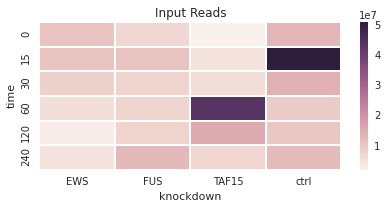

In [7]:
with dataviz.Figure(os.path.join(img_dir, "foo.svg"), figsize=(6,3)) as fig:
    ax = fig.add_subplot(1,1,1)
    sns.heatmap(fet_clip['Input Reads'].unstack().astype(float), ax=ax)
    ax.set_title("Input Reads")

Figure Legend: Heatmap of numbers of input reads, x axis is knockdown and y axis is time (in min)

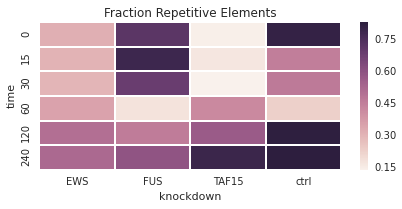

In [8]:
with dataviz.Figure(os.path.join(img_dir, "foo.svg"), figsize=(6,3)) as fig:
    ax = fig.add_subplot(1,1,1)
    sns.heatmap(fet_clip['Percent Repetative'].unstack().astype(float), ax=ax)
    ax.set_title("Fraction Repetitive Elements")

Figure Legend: Heatmap of Fraction of repetitive elements, x axis is knockdown and y axis is time (in min)

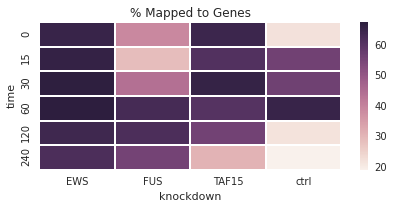

In [9]:
with dataviz.Figure(os.path.join(img_dir, "foo.svg"), figsize=(6,3)) as fig:
    ax = fig.add_subplot(1,1,1)
    sns.heatmap(mapped_counts.unstack().astype(float), ax=ax)
    ax.set_title("% Mapped to Genes")

Figure Legend: Heatmap of percent of reads mapped to genes, x axis is knockdown and y axis is time (in min)

Concluiosns
---

1. Number of input reads is highly varible
2. Number of % mapped to genes is inversely correlated to % of reads removed by repetitive elements.  This is because my rmRep Script isn't perfect and small differenes will not be observed / counted.


#Check knockdowns

In [10]:
def counts_to_rpkm(featureCountsTable):
    counts = featureCountsTable.ix[:,5:]
    lengths = featureCountsTable['Length']
    mapped_reads = counts.sum()
    return (counts * pow(10,9)).div(mapped_reads, axis=1).div(lengths, axis=0)


In [11]:
#MN
stabality_counts = pd.read_table("/nas3/gpratt/Dropbox/TAF15/Data/mRNA_stab/all_counts.txt", skiprows=1, index_col=0)
stabality_counts.columns = [os.path.basename(item).split(".")[0] for item in stabality_counts.columns]
stabality_rpkm = counts_to_rpkm(stabality_counts).T

mapper = {"NPC0": 0,
"NPC15": 15,
"NPC1": 60,
"NPC30": 30,
"NPC2": 120,
"NPC4": 4 * 60}

new_index = []
for item in stabality_rpkm.index:
    time, knockdown = item.split("_")
    new_index.append([mapper[time], knockdown])

stabality_rpkm.index = pd.MultiIndex.from_tuples(new_index, names=['time', 'knockdown'])
stabality_rpkm = stabality_rpkm.sort_index()
stabality_rpkm.columns.name = "gene"

'ENSG00000182944.13'

In [275]:
qc_columns = stabality_rpkm[[name_to_gene_id['TAF15'], 
                name_to_gene_id['FUS'],
                            name_to_gene_id['EWSR1']]]

qc_columns.columns = [gene_id_to_name[item] for item in qc_columns.columns]
qc_columns

TAF15       FUS      EWSR1
time knockdown                                
0    EWS         5.123467  4.759358  18.065110
     FUS         7.317535  2.601914  21.550330
     TAF15       4.538492  6.627954  23.471699
     ctrl        9.052099  4.875117  27.764298
15   EWS         5.658619  5.028187  16.685738
     FUS        10.255602  3.904387  21.730525
     TAF15       5.441408  7.591302  20.552736
     ctrl        7.052010  6.855542  21.637493
30   EWS         6.385247  5.826609  18.326145
     FUS         8.063613  3.901005  21.293340
     TAF15       4.367794  6.468314  24.381870
     ctrl        8.368377  8.739381  26.739055
60   EWS         5.997903  4.905184  17.291321
     FUS        11.869976  4.813618  22.747433
     TAF15       7.381043  6.120080  23.587750
     ctrl        6.812415  6.348181  27.847771
120  EWS         5.705355  5.425504  17.974680
     FUS         8.570592  2.563354  21.443721
     TAF15       4.207839  6.056584  22.724672
     ctrl        9.151162  8.232369  24.062052
240  EWS         5.648498  5.289999  15.622883
     FUS         7.941320  1.885512  17.376341
     TAF15       3.116117  5.733928  18.851022
     ctrl        6.263503  6.829862  24.550430

Conclusions
---

knockdown appeared to work (for the most part), will want to check how many genes actually show global decay, relative to genes with long halflives

#Unnormalized half-lives for RPKMs, to see if time series analysis might work

RLP27, RLP13

In [13]:
stabality_rpkm_log = np.log10(stabality_rpkm)

In [110]:
def calculate_half_lives(df):
    values = ["slope", "intercept", "r-value", "p-value", "stderr"]

    results = {}
    for knockdown, df in df.groupby(level=["knockdown"]):
        df[np.isneginf(df) | np.isinf(df)] = np.nan
        df = df.dropna(axis=1)
        result = {}
        for index in df.columns:
            regression = linregress(df.index.get_level_values(level="time"), df[index])
            result[index] = dict(zip(values, regression))
        result = pd.DataFrame(result).T
        results[knockdown] = result
    half_lives = pd.concat(results, names=['knockdown', 'gene'])
    #Think about making this a bit more robust, maybe doing fitting if all contigous values are there or something
    #Calculate other stuffs
    half_lives['r2'] = half_lives['r-value']**2
    half_lives['decay'] = half_lives['slope'] * -1
    half_lives['halflife'] = half_lives.decay.apply(lambda x: np.log(2) / x)
    return half_lives

def shuffle(df, n=1, axis=0):   
    #Shuffles df by columns or rows
    df = df.copy()
    for _ in range(n):
        df.apply(np.random.shuffle, axis=axis)
    return df

def shuffle_stabality_df(stabality_df):
    #shuffles multi-index by columns or rows given groupby statement
    result = {}
    for name, df in stabality_rpkm_log.groupby(level="knockdown"):
        result[name] = shuffle(df)
    result = pd.concat(result)
    return result

In [ ]:
half_lives = calculate_half_lives(stabality_rpkm_log)
shuffled_half_lives = calculate_half_lives(shuffle_stabality_df(stabality_rpkm_log))

Drop timepoint 0, apparently its worse...

In [ ]:
trimmed_stabality_rpkm_log = stabality_rpkm_log.drop(0, level="time")

trimmed_half_lives = calculate_half_lives(trimmed_stabality_rpkm_log)
trimmed_shuffled_half_lives = calculate_half_lives(shuffle_stabality_df(trimmed_stabality_rpkm_log))


In [121]:
all_halflives = pd.concat({"half_lives": half_lives,
 "shuffled_half_lives": shuffled_half_lives,
 "trimmed_half_lives": trimmed_half_lives,
 "trimmed_shuffled_half_lives": trimmed_shuffled_half_lives,}, names=['exp', 'knockdown', 'gene'])

Plot Decay Rate for all samples

In [122]:
good_halflives = all_halflives[all_halflives.decay > 0]

In [276]:
all_halflives.groupby(level=['exp', 'knockdown']).count().intercept.unstack()

knockdown,EWS,FUS,TAF15,ctrl
exp,,,,
half_lives,16663,15420,15989,14189
shuffled_half_lives,16663,15420,15989,14189
trimmed_half_lives,16690,16032,16415,14674
trimmed_shuffled_half_lives,16663,15420,15989,14189


Check R2 for things thrown out

In [273]:
good_halflives.groupby(level=['exp', 'knockdown']).count().intercept.unstack()

knockdown,EWS,FUS,TAF15,ctrl
exp,,,,
half_lives,9023,8322,8837,8277
shuffled_half_lives,8125,7405,7701,6868
trimmed_half_lives,9128,8889,8947,8585
trimmed_shuffled_half_lives,8014,7593,7823,6805


In [132]:
colors = sns.color_palette("Set2", 4)

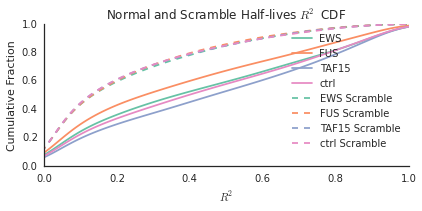

In [147]:
with dataviz.Figure(os.path.join(img_dir, "foo.svg"), figsize=(6,3)) as fig:
    ax = fig.add_subplot(1,1,1)
    for (name, df), color in zip(good_halflives.ix['half_lives'].groupby(level="knockdown"), colors):
        sns.kdeplot(df.r2, cumulative=True, label=name, color=color, ax=ax)
    
    for (name, df), color in zip(good_halflives.ix['shuffled_half_lives'].groupby(level="knockdown"), colors):
        sns.kdeplot(df.r2, cumulative=True, label=name+ " Scramble", linestyle="--", color=color, ax=ax)
    
    ax.set_xlim(0,1)
    sns.despine(ax=ax)
    ax.set_title("Normal and Scramble Half-lives $R^2$ CDF")
    ax.set_xlabel("$R^2$")
    ax.set_ylabel("Cumulative Fraction")
    ax.legend()

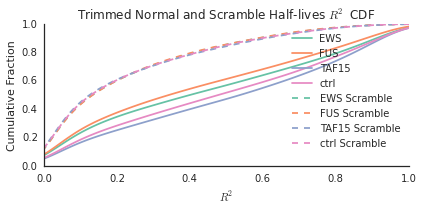

In [169]:
with dataviz.Figure(os.path.join(img_dir, "foo.svg"), figsize=(6,3)) as fig:
    ax = fig.add_subplot(1,1,1)
    for (name, df), color in zip(good_halflives.ix['trimmed_half_lives'].groupby(level="knockdown"), colors):
        sns.kdeplot(df.r2, cumulative=True, label=name, color=color, ax=ax)
    
    for (name, df), color  in zip(good_halflives.ix['trimmed_shuffled_half_lives'].groupby(level="knockdown"), colors):
        sns.kdeplot(df.r2, cumulative=True, label=name + " Scramble", linestyle="--", color=color, ax=ax)
    
    ax.set_xlim(0,1)
    ax.set_title("Trimmed Normal and Scramble Half-lives $R^2$ CDF")
    ax.set_xlabel("$R^2$")
    ax.set_ylabel("Cumulative Fraction")
    sns.despine(ax=ax)
    ax.legend()

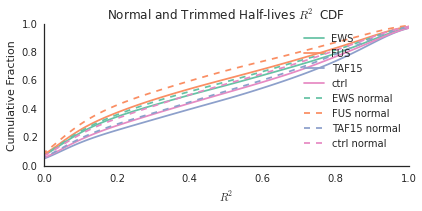

In [149]:
with dataviz.Figure(os.path.join(img_dir, "foo.svg"), figsize=(6,3)) as fig:
    ax = fig.add_subplot(1,1,1)
    for (name, df), color in zip(good_halflives.ix['trimmed_half_lives'].groupby(level="knockdown"), colors):
        sns.kdeplot(df.r2, cumulative=True, label=name, color=color, ax=ax)
    
    for (name, df), color  in zip(good_halflives.ix['half_lives'].groupby(level="knockdown"), colors):
        sns.kdeplot(df.r2, cumulative=True, label=name + " normal", linestyle="--", color=color, ax=ax)
    
    ax.set_xlim(0,1)
    sns.despine(ax=ax)
    ax.set_title("Normal and Trimmed Half-lives $R^2$ CDF")
    ax.set_xlabel("$R^2$")
    ax.set_ylabel("Cumulative Fraction")
    ax.legend()

#Method:
The equation I'm trying to fit is N(t) = $N_0e^{-\lambda t}$
If you take the ln of each side

ln(N(t)) = $ln(N_0) + -\lambda t$

You can fit this via linear regression, where slope = $-\lambda$

For scramble control I scrambled time points for the same gene.

#Conclusions
1. Scramble has somewhat uniform error, and is always worse than normal, which is good
2. If you trim off $T_0$ you get strictly better results from fitting the linear regression.  Could this be because you've just got fewer datapoints to fit?

#Final Dataset Choices
Because trimming is better I'm just going to use that dataset for the rest of the analysis
Really don't know if trimming is better, need to hit on it a bit more

All trimmed half-lives where we have high confidence values for control and the thing of interest

In [298]:
well_correlated_halflives = good_halflives[good_halflives.r2 > .6]
high_confidence_halflives = well_correlated_halflives.ix['trimmed_half_lives']
high_confidence_halflives = high_confidence_halflives.halflife.unstack()

#Descriptive Stats

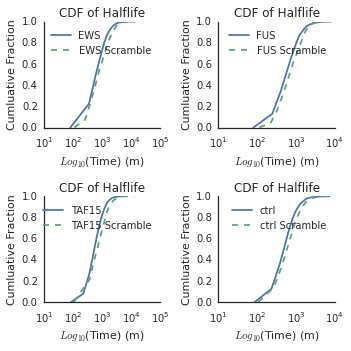

In [309]:
num_rows = 2
num_cols = 2
with dataviz.Figure(os.path.join(img_dir, "foo.svg"), figsize=(num_cols * 2.5, num_rows * 2.5)) as fig:
    for x, (name, df) in enumerate(well_correlated_halflives.groupby(level="knockdown")):
        ax = fig.add_subplot(2,2,x+1)
        
        dataviz.plot_cdf(df.ix['trimmed_half_lives'].halflife,
                         label=name, 
                         #color=colors[x], 
                         ax=ax)
        dataviz.plot_cdf(df.ix['trimmed_shuffled_half_lives'].halflife, 
                         label=name + " Scramble", 
                         linestyle="--", 
                         #color=color, 
                         ax=ax)

        ax.set_title("CDF of Halflife")
        ax.set_ylabel("Cumluative Fraction")
        ax.set_xlabel("$Log_{10}$(Time) (m)")
        ax.set_xscale("log", basex=10)
        ax.legend()
        sns.despine(ax=ax)

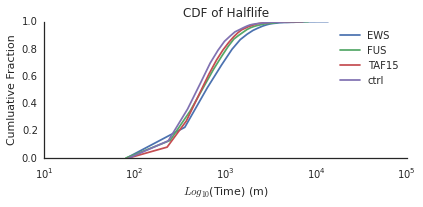

In [296]:
with dataviz.Figure(os.path.join(img_dir, "foo.svg"), figsize=(6,3)) as fig:
    ax = fig.add_subplot(1,1,1)
    
    #add in scrambles
    #log time scale
    for name, df in high_confidence_halflives.groupby(level="knockdown"):
            dataviz.plot_cdf(df.irow(0).dropna(), label=name, ax=ax)
    ax.legend(loc=0)
    #ax.set_xlim(0, 2000)
    ax.set_title("CDF of Halflife")
    ax.set_ylabel("Cumluative Fraction")
    ax.set_xlabel("$Log_{10}$(Time) (m)")
    ax.set_xscale("log", basex=10)
    sns.despine(ax=ax)

#Identify RNAs with large $\Delta$ half-life


In [168]:
delta_halflife_prep = high_confidence_halflives[high_confidence_halflives.ix['ctrl'].dropna().index]
delta_halflife = delta_halflife_prep - delta_halflife_prep.ix['ctrl']

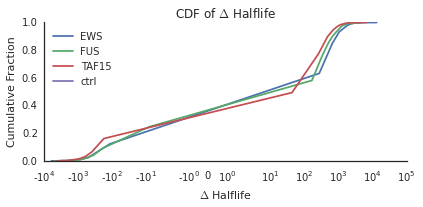

In [310]:
with dataviz.Figure(os.path.join(img_dir, "foo.svg"), figsize=(6,3)) as fig:
    ax = fig.add_subplot(1,1,1)

    for name, df in delta_halflife.groupby(level="knockdown"):
            dataviz.plot_cdf(df.irow(0).dropna(), label=name, ax=ax)
    ax.legend(loc=0)
    #ax.set_xlim(-500, 500)
    ax.set_title("CDF of $\Delta$ Halflife")
    ax.set_ylabel("Cumulative Fraction")
    ax.set_xlabel("$\Delta$ Halflife")
    ax.set_xscale("symlog", basex=10)
    sns.despine(ax=ax)

In [214]:
taf15_delta_genes = delta_halflife.ix['TAF15'].dropna()
taf15_delta_genes.sort()

In [220]:
taf15_stabalized_df = pd.concat({"Stabalized": taf15_delta_genes[taf15_delta_genes > 0],
"Destabalized": taf15_delta_genes[taf15_delta_genes < 0]}, names=['type'])

In [222]:
taf15_stabalized_df.groupby(level="type").count()

type
Destabalized     751
Stabalized      1133
Name: TAF15, dtype: int64

TODO: Label $\Delta$ halflife

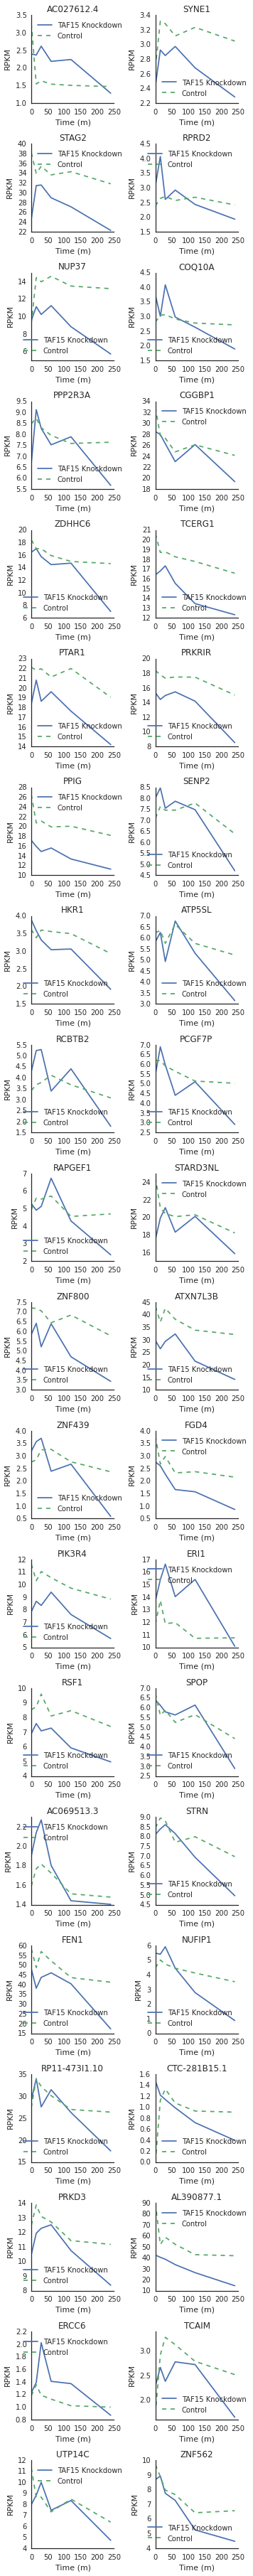

In [313]:
stabality_group = stabality_rpkm.groupby(level="knockdown")
num_genes = 40
num_rows = (num_genes / 2) + 1 
num_cols = 2
with dataviz.Figure(os.path.join(img_dir, "foo.svg"), figsize=(num_cols * 2.5,num_rows * 2.5)) as fig:
    for x, gene in enumerate(taf15_stabalized_df.ix['Destabalized'][:num_genes].index):
        ax = fig.add_subplot(num_rows,num_cols, x + 1)
        kd = foo.get_group("TAF15")[gene]
        ctrl = foo.get_group("ctrl")[gene]
        ax.plot(kd.index.get_level_values(level="time"), kd.values, label="TAF15 Knockdown")
        ax.plot(ctrl.index.get_level_values(level="time"), ctrl.values, label="Control", linestyle="--")
        ax.set_title(gene_id_to_name[gene])
        ax.set_xlabel("Time (m)")
        ax.set_ylabel("RPKM")
        sns.despine(ax=ax)
        ax.legend(loc=0)

Figure Legend: Top 40 most destabalized TAF15 Genes

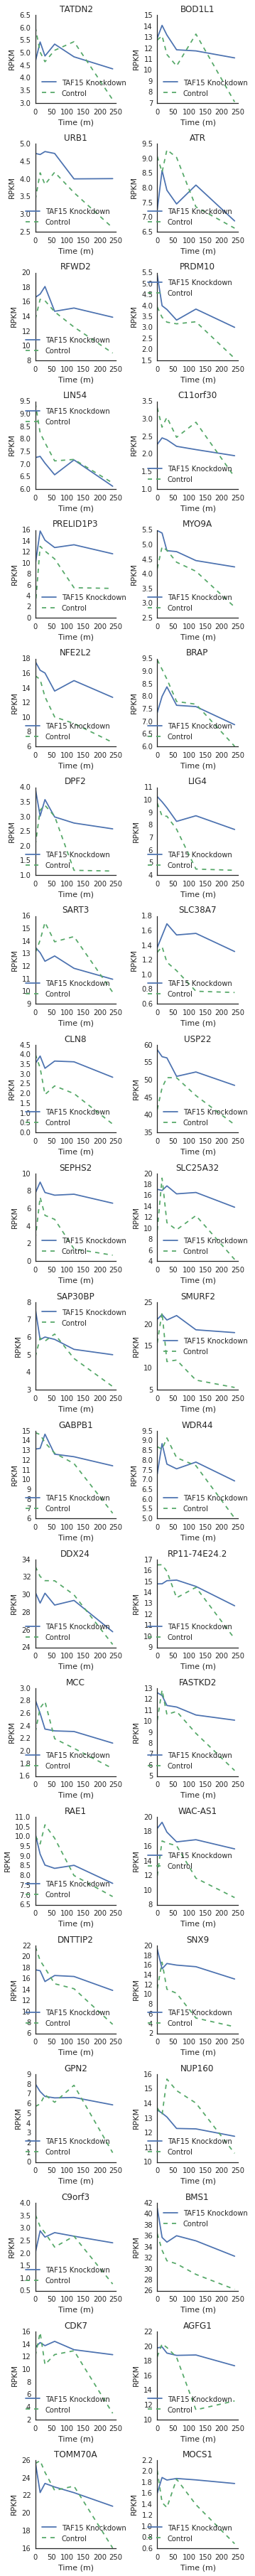

In [318]:
stabality_group = stabality_rpkm.groupby(level="knockdown")
num_genes = 40
num_rows = (num_genes / 2) + 1
num_cols = 2
with dataviz.Figure(os.path.join(img_dir, "foo.svg"), figsize=(num_cols * 2.5,num_rows * 2.5)) as fig:
    for x, gene in enumerate(taf15_stabalized_df.ix['Stabalized'][-1 * num_genes:].index):
        ax = fig.add_subplot(num_rows,num_cols, x + 1)
        kd = foo.get_group("TAF15")[gene]
        ctrl = foo.get_group("ctrl")[gene]
        ax.plot(kd.index.get_level_values(level="time"), kd.values, label="TAF15 Knockdown")
        ax.plot(ctrl.index.get_level_values(level="time"), ctrl.values, label="Control", linestyle="--")
        ax.set_title(gene_id_to_name[gene])
        ax.set_xlabel("Time (m)")
        ax.set_ylabel("RPKM")
        sns.despine(ax=ax)
        ax.legend(loc=0)

Figure Legend: Top 40 Most stabalized TAF15 Genes

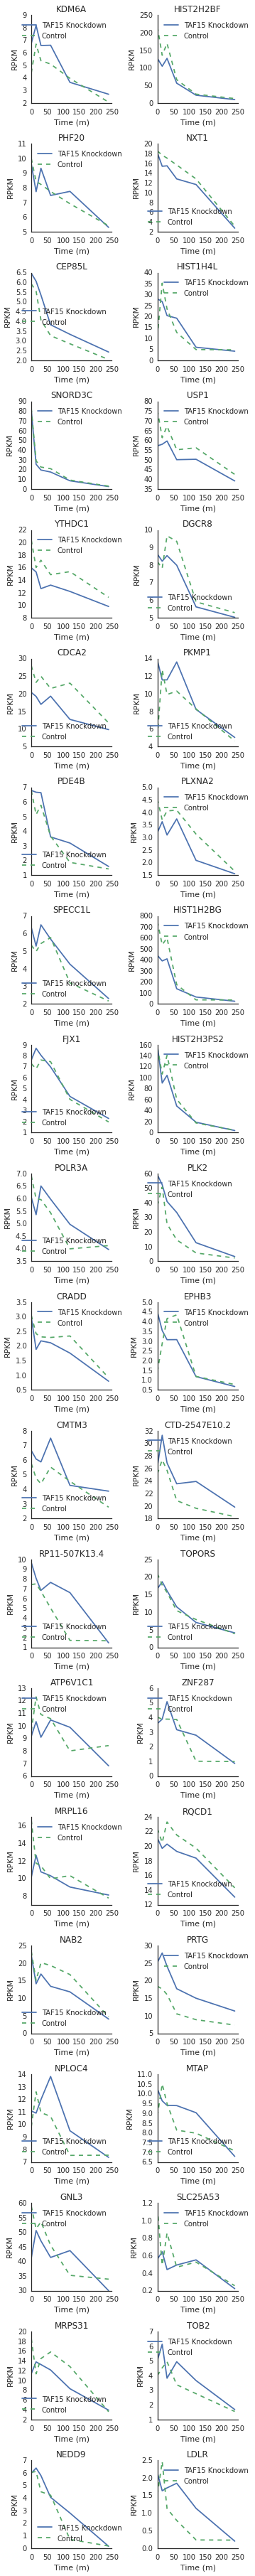

In [322]:
stabality_group = stabality_rpkm.groupby(level="knockdown")
num_genes = 40
num_rows = (num_genes / 2) + 1
num_cols = 2
count = 0
with dataviz.Figure(os.path.join(img_dir, "foo.svg"), figsize=(num_cols * 2.5,num_rows * 2.5)) as fig:
    for x, gene in enumerate(taf15_stabalized_df.ix['Stabalized'][:num_genes / 2].index):
        count += 1

        ax = fig.add_subplot(num_rows,num_cols, count)
        kd = foo.get_group("TAF15")[gene]
        ctrl = foo.get_group("ctrl")[gene]
        ax.plot(kd.index.get_level_values(level="time"), kd.values, label="TAF15 Knockdown")
        ax.plot(ctrl.index.get_level_values(level="time"), ctrl.values, label="Control", linestyle="--")
        ax.set_title(gene_id_to_name[gene])
        ax.set_xlabel("Time (m)")
        ax.set_ylabel("RPKM")
        sns.despine(ax=ax)
        ax.legend(loc=0)
        
    for x, gene in enumerate(taf15_stabalized_df.ix['Destabalized'][-1 * (num_genes / 2):].index):
        count += 1

        ax = fig.add_subplot(num_rows,num_cols, count)
        kd = foo.get_group("TAF15")[gene]
        ctrl = foo.get_group("ctrl")[gene]
        ax.plot(kd.index.get_level_values(level="time"), kd.values, label="TAF15 Knockdown")
        ax.plot(ctrl.index.get_level_values(level="time"), ctrl.values, label="Control", linestyle="--")
        ax.set_title(gene_id_to_name[gene])
        ax.set_xlabel("Time (m)")
        ax.set_ylabel("RPKM")
        sns.despine(ax=ax)
        ax.legend(loc=0)

Figure Legend: Top 40 least changing genes, first 20 are the least $\Delta$ increase in stabality. Second 20 are the least $\Delta$ decrease in stabality